<a href="https://colab.research.google.com/github/sminHSV/CS591_Assignment1/blob/main/The_Galactic_Voyager_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Galactic Voyager: Predicting the Transported Settlers

Welcome to the Galactic Voyager Anomaly Lab! In this lab, you will be working with data from the Galactic Voyager, an intergalactic cruiser that faced an unexpected event while navigating near Alpha Centauri en route to its primary destination—the torrid 55 Cancri E.

## Objective

Your mission is to predict which settlers were transported to an alternate dimension during the Galactic Voyager's encounter with a spacetime distortion. To aid you in making these predictions, you have been provided with a dataset containing personal records salvaged from the ship's compromised database.

## Dataset

The dataset consists of personal records of the settlers. Here's a brief overview of the data fields:

- `PassengerId`: A unique Id for each settler.
- `HomeGalaxy`: The galaxy the settler departed from.
- `CryoSleep`: Indicates if the settler was in suspended animation.
- `Cabin`: The cabin number where the settler stayed.
- `Destination`: The planet the settler intended to reach.
- ... [Other Fields]

Your primary objective is to predict the `Transported` field, which indicates whether a settler was transported to an alternate dimension.

## Getting Started with TensorFlow and Random Forest Model

To begin, you'll need to use the TensorFlow library and specifically work with the Random Forest model. Here's a basic template to help you get started:

```python
import tensorflow as tf     #make sure to install tensorflow in googleColab by running the following command: pip install tensorflow_decision_forests
import tensorflow_decision_forests as tfdf
import pandas as pd


# Load the dataset
dataset_df = pd.read_csv('path_to_train.csv')

# Convert the dataset to TensorFlow format
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(dataset_df, label="Transported")

# Create a Random Forest model
model = tfdf.keras.RandomForestModel()
model.fit(train_ds)

# Evaluate the model (Optional)
model.evaluate(train_ds)


In [97]:
from google.colab import drive
drive.mount('/content/drive')

!apt-get install git

!git clone https://github.com/sminHSV/CS591_Assignment1.git

Mounted at /content/drive
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.10).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
Cloning into 'CS591_Assignment1'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 18 (delta 5), reused 15 (delta 4), pack-reused 0
Receiving objects: 100% (18/18), 1.42 MiB | 3.72 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [ ]:
!pip install -q tensorflow_decision_forests
!pip install -q dtreeviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 3.4 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf     #make sure to install tensorflow in googleColab by running the following command: pip install tensorflow_decision_forests
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import re
import matplotlib
import matplotlib.pyplot as plt
import random
import string
import dtreeviz

# Load the dataset
dataset_df = pd.read_csv('train.csv')

def process_data(df, *args, **kwargs):
  id = re.compile(r'(?P<group>\d{4})_(?P<position>\d{2})')
  df = df.assign(Group=df['PassengerId'].apply(lambda x: (pd.notna(x) and id.match(x).group('group') or x)))
  df = df.assign(Position=df['PassengerId'].apply(lambda x: (pd.notna(x) and id.match(x).group('position') or x)))
  df = df.drop(columns=['PassengerId'])

  cabin = re.compile(r'(?P<deck>[A-Z])/(?P<num>\d+)/(?P<side>[P,S])')
  df = df.assign(CabinDeck= df['Cabin'].apply(lambda x: (pd.notna(x) and cabin.match(x).group('deck') or x)))
  df = df.assign(CabinNum=  df['Cabin'].apply(lambda x: (pd.notna(x) and cabin.match(x).group('num') or x)))
  df = df.assign(CabinSide= df['Cabin'].apply(lambda x: (pd.notna(x) and cabin.match(x).group('side') or x)))
  df = df.drop(columns=['Cabin'])

  name = re.compile(r'(?P<first>\w+) (?P<last>\w+)')
  df = df.assign(FirstName= df['Name'].apply(lambda x: (pd.notna(x) and name.match(x).group('first') or x)))
  df = df.assign(LastName=  df['Name'].apply(lambda x: (pd.notna(x) and name.match(x).group('last') or x)))
  df = df.drop(columns=['Name'])

  if kwargs.get('fillname', True):
    missing_names = df['FirstName'].isna()
    for i in missing_names[missing_names].index:
      df.at[i, 'FirstName'] = random.choice(df['FirstName'])
      if i > 0 and df.at[i-1, 'Group'] and df.at[i-1, 'Group'] == df.at[i, 'Group']:
        df.at[i, 'LastName'] = df.at[i-1, 'LastName']
      else:
        df.at[i, 'LastName'] = random.choice(df['LastName'])

  if kwargs.get('fillhome', True):
    missing = df['HomePlanet'].isna()
    for i in missing[missing].index:
      if i == 0:
        continue
      if df.at[i-1, 'Group'] == df.at[i, 'Group']:
        df.at[i, 'HomePlanet'] = df.at[i-1, 'HomePlanet']

  if kwargs.get('filldest', True):
    missing = df['Destination'].isna()
    for i in missing[missing].index:
      if i == 0:
        continue
      if df.at[i-1, 'Group'] == df.at[i, 'Group']:
        df.at[i, 'Destination'] = df.at[i-1, 'Destination']

  if kwargs.get('fillvip', True):
    df['VIP'].fillna(False, inplace=True)

  if kwargs.get('fillbill', True):
    df['RoomService'] = df['RoomService'].fillna(0.0)
    df['FoodCourt'] = df['FoodCourt'].fillna(0.0)
    df['ShoppingMall'] = df['ShoppingMall'].fillna(0.0)
    df['Spa'] = df['Spa'].fillna(0.0)
    df['VRDeck'] = df['VRDeck'].fillna(0.0)

  df = df.dropna()
  df = df.astype({
      'Transported' : 'int32',
      'VIP' :         'int32',
      'CryoSleep' :   'int32'
  })

  df = df.assign(OrderedRoomService=    df['RoomService'].apply(lambda x: 1 if x > 0 else 0))
  df = df.assign(VisitedFoodCourt=      df['FoodCourt'].apply(lambda x: 1 if x > 0 else 0))
  df = df.assign(VisitedShoppingMall=   df['ShoppingMall'].apply(lambda x: 1 if x > 0 else 0))
  df = df.assign(VisitedSpa=            df['Spa'].apply(lambda x: 1 if x > 0 else 0))
  df = df.assign(VisitedVRDeck=         df['VRDeck'].apply(lambda x: 1 if x > 0 else 0))

  df = df.assign(TotalSpent=df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck'])
  class_ = df.groupby('Group').agg(Class=('TotalSpent', lambda x: np.log10(1 + sum(x))))
  df = df.merge(class_, on='Group', how='left')

  return df

dataset_df = process_data(dataset_df)
print(dataset_df)

     HomePlanet  CryoSleep    Destination   Age  VIP  RoomService  FoodCourt  \
0        Europa          0    TRAPPIST-1e  39.0    0          0.0        0.0   
1         Earth          0    TRAPPIST-1e  24.0    0        109.0        9.0   
2        Europa          0    TRAPPIST-1e  58.0    1         43.0     3576.0   
3        Europa          0    TRAPPIST-1e  33.0    0          0.0     1283.0   
4         Earth          0    TRAPPIST-1e  16.0    0        303.0       70.0   
...         ...        ...            ...   ...  ...          ...        ...   
7842     Europa          0    55 Cancri e  41.0    1          0.0     6819.0   
7843      Earth          1  PSO J318.5-22  18.0    0          0.0        0.0   
7844      Earth          0    TRAPPIST-1e  26.0    0          0.0        0.0   
7845     Europa          0    55 Cancri e  32.0    0          0.0     1049.0   
7846     Europa          0    TRAPPIST-1e  44.0    0        126.0     4688.0   

      ShoppingMall     Spa  VRDeck  ...

In [ ]:
num_transported = dataset_df['Transported'].aggregate('sum')
print('% Transported: {:.2f}'.format(num_transported / len(dataset_df)))

group_ratios = dataset_df.groupby('Group')['Transported'].agg(
    lambda x: max(sum(x), len(x) - sum(x)) / len(x) if len(x) > 1 else 0)

group_ratios = group_ratios.loc[group_ratios != 0]
print('Average Ratio Per Group: {:.2f}'.format(group_ratios.aggregate('sum') / len(group_ratios)))

In [ ]:
fig = plt.figure()

def plot_by_group(df, column):
  grouped = df.groupby([column]).agg(
      Transported=('Transported', 'sum'),
      NotTransported=('Transported', lambda x: len(x) - sum(x))
  )
  grouped.plot(kind='bar', stacked=True, rot=0)
  plt.show()

def plot_by_value(df, column, log=False, filter=[]):
  if len(filter) == 0:
    filter = np.full(len(df), 1)
  transported = df.loc[(df['Transported'] == 1) & (filter == 1)][column]
  notTransported = df.loc[(df['Transported']) == 0 & (filter == 1)][column]

  ax = plt.subplot()
  ax.hist([transported, notTransported], bins=80, histtype='barstacked', log=log, label=['Transported', 'NotTransported'])
  ax.legend()
  ax.set_xlabel(column)
  plt.show()

plot_by_group(dataset_df, 'HomePlanet')
plot_by_group(dataset_df, 'CryoSleep')
plot_by_group(dataset_df, 'Destination')
plot_by_value(dataset_df, 'Age')
plot_by_group(dataset_df, 'VIP')
#plot_by_value(dataset_df, 'RoomService', filter=dataset_df['OrderedRoomService'])
#plot_by_value(dataset_df, 'FoodCourt', filter=dataset_df['VisitedFoodCourt'])
#plot_by_value(dataset_df, 'ShoppingMall', filter=dataset_df['VisitedShoppingMall'])
#plot_by_value(dataset_df, 'Spa', filter=dataset_df['VisitedSpa'])
#plot_by_value(dataset_df, 'VRDeck', filter=dataset_df['VisitedVRDeck'])
plot_by_value(dataset_df, 'TotalSpent')
plot_by_value(dataset_df, 'Class')
plot_by_group(dataset_df, 'Position')
plot_by_group(dataset_df, 'CabinDeck')
plot_by_group(dataset_df, 'CabinSide')

In [ ]:
# Select features
features = ['Class', 'Age', 'CryoSleep', 'Transported', 'CabinSide',
            'CabinDeck', 'HomePlanet', 'Destination',
            'OrderedRoomService',
            'VisitedFoodCourt',
            'VisitedShoppingMall',
            'VisitedSpa',
            'VisitedVRDeck'
            ]

# Convert the dataset to TensorFlow format
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(dataset_df[features], label="Transported")

tuner = tfdf.tuner.RandomSearch()

# Create a Random Forest model
model = tfdf.keras.RandomForestModel(
    tuner=tuner,
    growing_strategy='BEST_FIRST_GLOBAL',
    max_num_nodes=30,
    min_examples=500
)
model.compile(metrics=['accuracy'])
model.fit(train_ds)

Use /tmp/tmpt0dwxnqs as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.352827. Found 7847 examples.
Training model...
Model trained in 0:00:02.164216
Compiling model...
Model compiled.


In [ ]:
model.summary()

In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, max_depth=5)

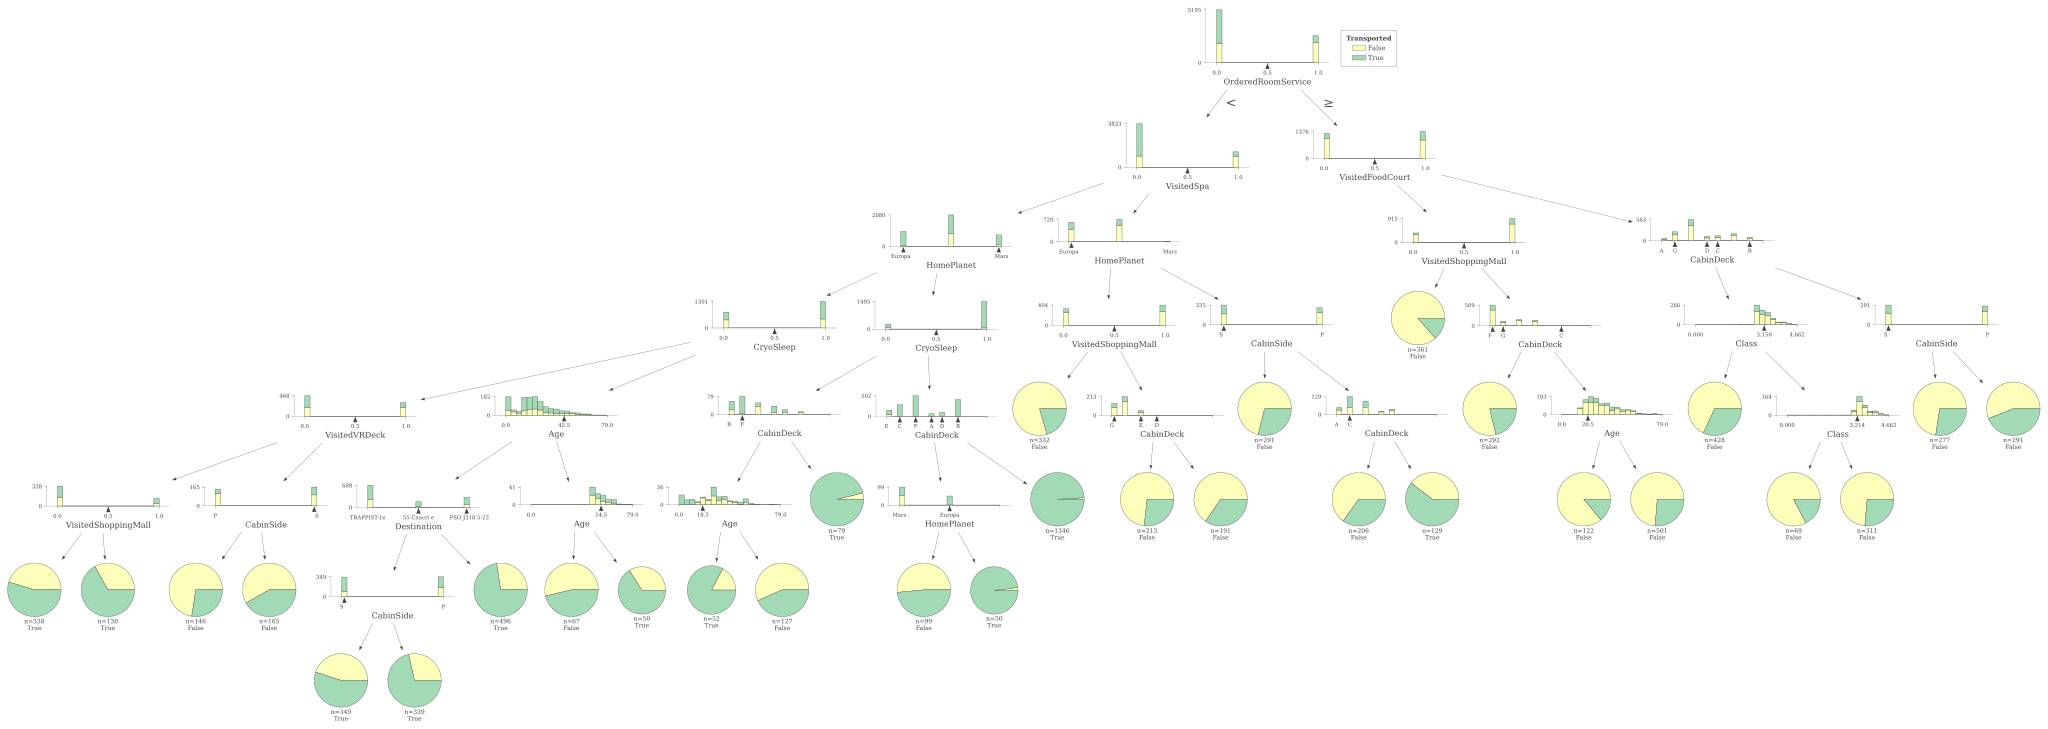

In [ ]:
viz_model = dtreeviz.model(
    model,
    tree_index=299,
    X_train=dataset_df[features],
    y_train=dataset_df['Transported'],
    feature_names=features,
    target_name='Transported',
    class_names=['False', 'True'])

viz_model.view(fontname='serif')